# Elastic Membrane Problem using FEM

We look for the deflection of an elastic membrane due  to a spatially varying body force. The problem is described by the Poisson equation

$$
\nabla^2 u = -g(x)\\
u=0 \text{ on } \partial\Omega 
$$

## Variational Form of Poisson's Equation

To obtain a variational form, we first multiply with a test function $v$ and then integrate

$$
\int_\Omega \nabla^2 u\cdot v\,dx = -\int_\Omega g\cdot v\,dx
$$

Most finite element basis sets can deal with first order derivatives, but not second order derivatives (because they are linear). Integration by parts allows to reduce the order of the PDE:

$$
\int \nabla^2 u\cdot v\,dx = \int_{\partial\Omega} \nabla u\cdot v\,ds - \int_\Omega \nabla u\cdot \nabla v\,dx
$$

The test function $v$ is *arbitrary* and we can choose functions that vanish on the boundary so that Poisson problem in variational form reads:

$$
\int_\Omega \nabla u\cdot \nabla v\,dx = \int_\Omega g\cdot v\,dx
$$

### A word on boundary conditions

Using integration by parts as part of the construction of the variational form often leads to surface integrals along the boundary being part of the variational form. Parts of the boundary that are naturally expressed by these terms are called **natural boundary conditions**. Neumann boundary conditions are natural boundary conditions for the Poisson equation. Other boundary conditions need to be incorporated when constructing the basis set for the test functions. These boundary conditions are called **essential boundary conditions**. Both types can be mixed, but they need to be treated differently in the machinery.

# Finite-Element Problem

We will use [FEniCS](https://fenicsproject.org/) to solve the variational form of Poissons equation. FEniCS is a 
platform to efficiently solve PDEs using the Finite-Element method. To solve a PDE in FEniCS, the following general steps
need to be completed:
    
1. Formulate the problem in variational form, reducing higher order terms using integration by parts
2. Discretise the computational domain into a mesh
3. Select function spaces for the trial and test function
4. Define *essential* boundary conditions
5. Solve the problem

The FEniCS Project consists of a number of components with DOLFIN and UFL providing the 
main user interface. Lets start by importing the dolfin package:

In [1]:
from dolfin import *

## Define domain

We begin by defining a mesh of the domain and a finite element
function space $V$ relative to this mesh. As the unit square is
a very standard domain, we can use a built-in mesh provided by the
`UnitSquareMesh`. In order
to create a mesh consisting of 16 x 16 squares with each square
divided into two triangles, we do as follows:

In [17]:
mesh = UnitSquareMesh.create(32,32,CellType.Type.triangle);

Lets have a look at the mesh. FEniCS comes with a few handy visualisation tools that work together with [matplotlib](https://matplotlib.org/), a very popular python library that provides a full suite of plotting tools.

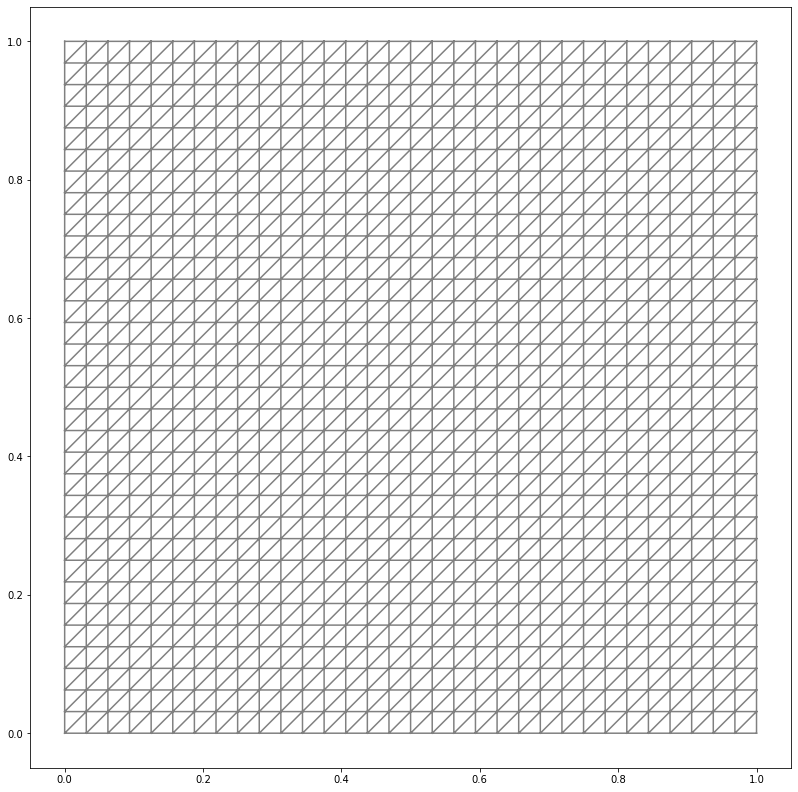

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(14,14))
plot(mesh)
plt.show()

## Define function spaces

Next we define the basis functions aka function space for trial and test function:

In [20]:
element = FiniteElement("P",triangle, 2)
V = FunctionSpace(mesh, element)

The second argument to `FunctionSpace` is the finite element
family, while the third argument specifies the polynomial
degree. Thus, in this case, our space `V` consists of first-order,
continuous Lagrange finite element functions (or in order words,
continuous piecewise linear polynomials).

## Boundary condition

### Define domain for essential BCs

Next, we want to consider the Dirichlet boundary condition. A simple
Python function, returning a boolean, can be used to define the
subdomain for the Dirichlet boundary condition $\Gamma_D`$. The
function should return `True` for those points inside the subdomain
and `False` for the points outside. In our case, we want to say that
the points $(x, y)$ such that $x = 0$ or $x = 1$ are
inside $\Gamma_D$. 
> Note that because of rounding-off errors, it is often wise to instead specify $x <
\epsilon$ or $x > 1 - \epsilon$ where $\epsilon$ is a small number (such as machine precision).

In [21]:
# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS or x[1] < DOLFIN_EPS or x[1] > 1.0 - DOLFIN_EPS

### Define Dirichlet boundary condition

Now, the Dirichlet boundary condition can be created using `DirichletBC`. A
`DirichletBC` takes three arguments: 

- the function space the boundary condition applies to, 
- the value of the boundary condition, and 
- the part of the boundary on which the condition applies. 

In our example, the function space is `V`, the value of the boundary condition (0.0) can represented using a
`Constant` and the Dirichlet boundary is defined immediately above. The definition of the
Dirichlet boundary condition then looks as follows:

In [22]:
# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

## Express Variational Problem

Next, we want to express the variational problem.  First, we need to
specify the trial function `u` and the test function `v`,
both living in the function space `V`. We do this by defining a
`TrialFunction` and a `TestFunction` on the previously defined
function space `V`.

In [23]:
# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)

Further, the source `g` is involved in the variational forms, and hence we must
specify it. `g` is given by a simple
mathematical formula, and can be easily declared using a
`Constant`.

In [24]:
g = Constant(1.0);

With these ingredients, we can write down the bilinear form ``a`` and
the linear form ``L`` (using UFL operators). In summary, this reads:

In [25]:
a = inner(grad(u), grad(v))*dx
L = g*v*dx 

## Solve

Now, we have specified the variational forms and can consider the
solution of the variational problem. First, we need to define a
`Function` ``u_sol`` to
represent the solution. (Upon initialization, it is simply set to the
zero function.) A `Function` represents a function living in
a finite element function space. Next, we can call the `solve` function with the arguments `a == L`,
`u_sol` and `bc` as follows:

In [26]:
# Compute solution
u_sol = Function(V)
solve(a == L, u_sol, bc)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


The function `u_sol` will be modified during the call to solve. The
default settings for solving a variational problem have been
used. However, the solution process can be controlled in much more
detail if desired.

## Visualise solution

A `Function` can be manipulated in various ways, in particular, it can be plotted and
saved to file. Here, we output the solution to a `VTK` file (using
the suffix ``.pvd``) for later visualization using [Paraview](https://www.paraview.org/) and also plot it using
the `plot` command:

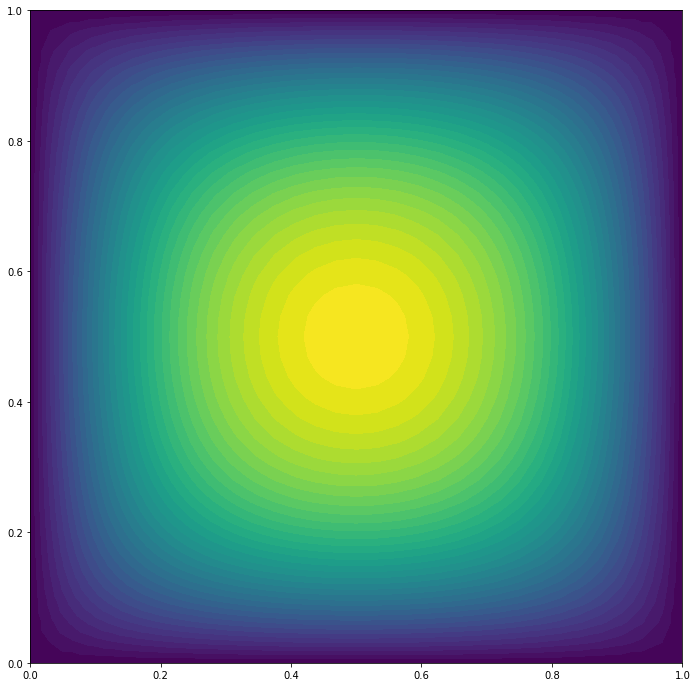

In [28]:
 # Save solution in VTK format
# file = File("/home/fenics/shared/poisson.pvd")
# file << u_sol

# Plot solution
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plot(u_sol)
plt.show()